In [2]:
import sys
import os
import yaml
import random
import argparse
import logging
import torch
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger, CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
)
from torchmdnet.module import LNNP
from torchmdnet import datasets, priors, models
from torchmdnet.data import DataModule
from torchmdnet.loss import loss_class_mapping
from torchmdnet.models import output_modules
from torchmdnet.models.model import create_prior_models
from torchmdnet.models.utils import rbf_class_mapping, act_class_mapping, dtype_mapping
from torchmdnet.utils import LoadFromFile, LoadFromCheckpoint, save_argparse, number
from lightning_utilities.core.rank_zero import rank_zero_warn
from torch.utils.data import ConcatDataset, Subset, SubsetRandomSampler, random_split

In [4]:
args = {
    "activation": "silu",
    "aggr": "add",
    "atom_filter": -1,
    "attn_activation": "silu",
    "batch_size": 1,
    "coord_files": None,
    "cutoff_lower": 0.0,
    "cutoff_upper": 5.0,
    "dataset": "Butene",
    "dataset_arg": {
        "root": "/home/amir/Projects/Butene_MD",
        "start": 1000,
        "end": 3000,
    },
    "dataset_root": "~/data",
    "derivative": False,
    "distance_influence": "both",
    "early_stopping_patience": 300,
    "ema_alpha_neg_dy": 1.0,
    "ema_alpha_y": 0.05,
    "embed_files": None,
    "embedding_dimension": 128,
    "energy_files": None,
    "y_weight": 0.2,
    "force_files": None,
    "neg_dy_weight": 0.8,
    "load_model": None,
    "log_dir": "logs/",
    "lr": 0.001,
    "lr_factor": 0.8,
    "lr_min": 1.0e-07,
    "lr_patience": 30,
    "lr_warmup_steps": 1000,
    "max_num_neighbors": 32,
    "max_z": 100,
    "model": "equivariant-transformer",
    "neighbor_embedding": True,
    "ngpus": -1,
    "num_epochs": 3000,
    "num_heads": 8,
    "num_layers": 6,
    "num_nodes": 1,
    "num_rbf": 32,
    "num_workers": 6,
    "output_model": "Scalar",
    "precision": 32,
    "prior_model": None,
    "rbf_type": "expnorm",
    "redirect": False,
    "reduce_op": "add",
    "save_interval": 10,
    "splits": None,
    "standardize": True,
    "test_interval": 5,
    "test_size": 1299,
    "train_size": 1,
    "trainable_rbf": False,
    "val_size": 1,
    "weight_decay": 0.0,
    "box_vecs": None,
    "charge": False,
    "spin": False,
    "vector_cutoff": True,
    "wandb_use": True,
    "wandb_project": "MD17-Mix_No_Ethanol",
    "tensorboard_use": True,
    "wandb_name": "ET-Transformer-Mix_No_Ethanol",
    "pairwise_thread": True,
    "triples_thread": True,
    "return_vecs": True,
    "loop": True,
    "base_cutoff": 5.0,
    "outer_cutoff": 5.0,
    "gradient_clipping": 0.0,
    "remove_ref_energy": False,
    "train_loss": "mse_loss",
    "train_loss_arg": None,
    "seed": 1,
    "dataset_preload_limit": 1024,
    "lr_metric": "val",
    "box": None,
    "long_edge_index": True,
    "check_errors": True,
    "strategy": "brute",
    "include_transpose": True,
    "resize_to_fit": True,
    "output_mlp_num_layers": 0,
    "equivariance_invariance_group": "O(3)",
    "static_shapes": False,
    "wandb_resume_from_id": None,
    "inference_batch_size": 1,
}

args = argparse.Namespace(**args)

# Now you can access the arguments as attributes of the args object
print(args.activation)

silu


In [5]:
data = DataModule(args)
data.prepare_data()
data.setup("fit")

/home/amir/Projects/torchmd-net/torchmdnet/utils.py:221: UserWarning: 700 samples were excluded from the dataset
  rank_zero_warn(f"{dset_len - total} samples were excluded from the dataset")


train 1, val 1, test 1299

computing mean and std: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
/home/amir/Projects/torchmd-net/torchmdnet/data.py:355: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730840128166/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  self._std = ys.std(dim=0)


In [6]:
prior_models = create_prior_models(vars(args), data.dataset)
args.prior_args = [p.get_init_args() for p in prior_models]
# initialize lightning module
model = LNNP(args, prior_model=prior_models, mean=data.mean, std=data.std)

In [7]:
trainer = pl.Trainer(
    strategy="auto",
    max_epochs=args.num_epochs,
    accelerator="cpu",
    # devices="cpu",
    num_nodes=args.num_nodes,
    default_root_dir=args.log_dir,
    # callbacks=[early_stopping, checkpoint_callback],
    # logger=_logger,
    precision=args.precision,
    gradient_clip_val=args.gradient_clipping,
    inference_mode=False,
    # Test-during-training requires reloading the dataloaders every epoch
    reload_dataloaders_every_n_epochs=1 if args.test_interval > 0 else 0,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amir/.conda/envs/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [8]:
def make_fft_plot(timeseries, ax, label):
    freq = np.fft.fftfreq(timeseries.shape[-1])
    spectrum  = np.fft.fft(timeseries)
    ax.plot(freq, spectrum.real, label=f'real + {label}')
    ax.plot(freq, spectrum.imag, label=f'imag + {label}')

In [12]:

def plot_fourier(ax, outputs_list):
    ax.plot(np.arange(outputs_list.shape[-1]), np.fft.fft(np.array(outputs_list)).imag)
    ax.plot(np.arange(outputs_list.shape[-1]), np.fft.fft(np.array(outputs_list)).real)

In [9]:
energies = [float(data.dataset[i]["y"]) for i in range(len(data.dataset))]

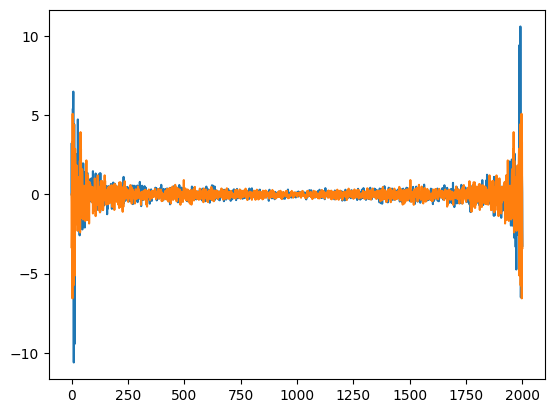

In [14]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

plot_fourier(ax, np.array(energies)- np.array(energies).mean())